In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import sys
sys.path.append('../')
from ptflops import get_model_complexity_info
import json

import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

from main.efficientnet import effnetv2_s, EffNetV2_FC, EffNetV2_FC_Branch
from main.trainer_domainnet import DomainNetTrainer
from main.layout import Layout
from main.algorithms import enum_layout_wo_rdt, init_S, coarse_to_fined
from data.domainnet_dataloader import DomainNet, MultiDomainSampler

### domainnet data - example

In [2]:
dataroot = '/work/lijunzhang_umass_edu/data/multibranch/data/DomainNet/'
tasks = ['real', 'painting', 'quickdraw', 'clipart', 'infograph', 'sketch']
cls_num = {task: 345 for task in tasks}

In [3]:
dataloader = {}

batch_size = 32
with open(os.path.join(dataroot, 'DomainNet.json'), 'r') as f:
    split_domain_info = json.load(f)
for mode in ['train','val']:
    random_shuffle = True if mode == 'train' else False
    sampler = MultiDomainSampler(split_domain_info, mode, batch_size, tasks, random_shuffle)
    dataset = DomainNet(dataroot, mode)
    print('size of %s dataset: ' % mode, len(dataset))
    dataloader[mode] = DataLoader(dataset, batch_sampler=sampler, num_workers=2)

size of train dataset:  409832
size of val dataset:  176740


In [8]:
# iters of each task
for task in ['real', 'painting', 'quickdraw', 'clipart', 'infograph', 'sketch']:
    with open(os.path.join(dataroot, task+'_train.txt'), 'r') as f:
        print(task,len(f.readlines())//batch_size)
    with open(os.path.join(dataroot, task+'_test.txt'), 'r') as f:
        print(task,len(f.readlines())//batch_size)

real 3778
real 1626
painting 1575
painting 682
quickdraw 3773
quickdraw 1617
clipart 1047
clipart 456
infograph 1125
infograph 486
sketch 1506
sketch 653


### model

In [2]:
projectroot = '/work/lijunzhang_umass_edu/data/multibranch/'

data = 'DomainNet'
dataroot = os.path.join(projectroot, 'data/', data)
# tasks = ['real', 'painting', 'quickdraw', 'clipart', 'infograph', 'sketch'] # or two_task for branched model
tasks = ['real']
cls_num = {task: 345 for task in tasks}
dataloader = {}

batch_size = 32
with open(os.path.join(dataroot, 'DomainNet.json'), 'r') as f:
    split_domain_info = json.load(f)
for mode in ['train','val']:
    random_shuffle = True if mode == 'train' else False
    sampler = MultiDomainSampler(split_domain_info, mode, batch_size, tasks, random_shuffle)
    dataset = DomainNet(dataroot, mode)
    dataloader[mode] = DataLoader(dataset, batch_sampler=sampler)
    print('size of %s dataloader: ' % mode, len(dataloader[mode]))

size of train dataloader:  3778
size of val dataloader:  327


In [3]:
coarse_B = 4
fined_B = 42
mapping = {0: [0, 1, 2, 3, 4, 5, 6], 1: [7, 8, 9, 10],
           2: [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25],
           3: [26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41], 4: [42]}

In [4]:
# branched model
branch = 0
print('Coarse Branch Point:', flush=True)
print(branch, flush=True)

branch = mapping[branch][0]
print('Fined Branch Point:', flush=True)
print(branch, flush=True)

# model = EffNetV2_FC(tasks=tasks, branch=branch, cls_num=cls_num).cuda()
model = EffNetV2_FC_Branch(tasks, branch, cls_num).cuda()

Coarse Branch Point:
0
Fined Branch Point:
0


In [6]:
# layout model
T = len(tasks)
    
layout_list = [] 
S0 = init_S(T, coarse_B) # initial state
L = Layout(T, coarse_B, S0) # initial layout
layout_list.append(L)

enum_layout_wo_rdt(L, layout_list)
print(len(layout_list))

Coarse Layout:
[[{0}, {1}, {3, 4, 5}, {2}], [{0}, {1}, {3, 4, 5}, {2}], [{0}, {1}, {3, 4, 5}, {2}], [{0}, {1}, {3, 4, 5}, {2}]]
Fined Layout:
[[{0}, {1}, {3, 4, 5}, {2}], [{0}, {1}, {3, 4, 5}, {2}], [{0}, {1}, {3, 4, 5}, {2}], [{0}, {1}, {3, 4, 5}, {2}], [{0}, {1}, {3, 4, 5}, {2}], [{0}, {1}, {3, 4, 5}, {2}], [{0}, {1}, {3, 4, 5}, {2}], [{0}, {1}, {3, 4, 5}, {2}], [{0}, {1}, {3, 4, 5}, {2}], [{0}, {1}, {3, 4, 5}, {2}], [{0}, {1}, {3, 4, 5}, {2}], [{0}, {1}, {3, 4, 5}, {2}], [{0}, {1}, {3, 4, 5}, {2}], [{0}, {1}, {3, 4, 5}, {2}], [{0}, {1}, {3, 4, 5}, {2}], [{0}, {1}, {3, 4, 5}, {2}], [{0}, {1}, {3, 4, 5}, {2}], [{0}, {1}, {3, 4, 5}, {2}], [{0}, {1}, {3, 4, 5}, {2}], [{0}, {1}, {3, 4, 5}, {2}], [{0}, {1}, {3, 4, 5}, {2}], [{0}, {1}, {3, 4, 5}, {2}], [{0}, {1}, {3, 4, 5}, {2}], [{0}, {1}, {3, 4, 5}, {2}], [{0}, {1}, {3, 4, 5}, {2}], [{0}, {1}, {3, 4, 5}, {2}], [{0}, {1}, {3, 4, 5}, {2}], [{0}, {1}, {3, 4, 5}, {2}], [{0}, {1}, {3, 4, 5}, {2}], [{0}, {1}, {3, 4, 5}, {2}], [{0}, {1}, {3, 4,

In [ ]:
layout_idx = 3
layout = layout_list[layout_idx]
print('Coarse Layout:', flush=True)
print(layout, flush=True)

layout = coarse_to_fined(layout, fined_B, mapping)
print('Fined Layout:', flush=True)
print(layout, flush=True)

In [7]:
model = EffNetV2_FC(tasks=tasks, layout=layout, cls_num=cls_num).cuda()

Construct MTSeqModel from Layout:
[[{0}, {1}, {3, 4, 5}, {2}], [{0}, {1}, {3, 4, 5}, {2}], [{0}, {1}, {3, 4, 5}, {2}], [{0}, {1}, {3, 4, 5}, {2}], [{0}, {1}, {3, 4, 5}, {2}], [{0}, {1}, {3, 4, 5}, {2}], [{0}, {1}, {3, 4, 5}, {2}], [{0}, {1}, {3, 4, 5}, {2}], [{0}, {1}, {3, 4, 5}, {2}], [{0}, {1}, {3, 4, 5}, {2}], [{0}, {1}, {3, 4, 5}, {2}], [{0}, {1}, {3, 4, 5}, {2}], [{0}, {1}, {3, 4, 5}, {2}], [{0}, {1}, {3, 4, 5}, {2}], [{0}, {1}, {3, 4, 5}, {2}], [{0}, {1}, {3, 4, 5}, {2}], [{0}, {1}, {3, 4, 5}, {2}], [{0}, {1}, {3, 4, 5}, {2}], [{0}, {1}, {3, 4, 5}, {2}], [{0}, {1}, {3, 4, 5}, {2}], [{0}, {1}, {3, 4, 5}, {2}], [{0}, {1}, {3, 4, 5}, {2}], [{0}, {1}, {3, 4, 5}, {2}], [{0}, {1}, {3, 4, 5}, {2}], [{0}, {1}, {3, 4, 5}, {2}], [{0}, {1}, {3, 4, 5}, {2}], [{0}, {1}, {3, 4, 5}, {2}], [{0}, {1}, {3, 4, 5}, {2}], [{0}, {1}, {3, 4, 5}, {2}], [{0}, {1}, {3, 4, 5}, {2}], [{0}, {1}, {3, 4, 5}, {2}], [{0}, {1}, {3, 4, 5}, {2}], [{0}, {1}, {3, 4, 5}, {2}], [{0}, {1}, {3, 4, 5}, {2}], [{0}, {1}, {3

In [5]:
Trainer = DomainNetTrainer(model, tasks, dataloader['train'], dataloader['val'], batch_size, lr=0.001)

In [6]:
savePath = os.path.join(projectroot, 'checkpoint/', data, 'exp/')
Trainer.train(iters=200, savePath=savePath)

[Iter 100 Task real] Train Loss: 5.8713
[Iter 100 Total] Train Loss: 5.8713
[Iter 200 Task real] Train Loss: 5.7653
[Iter 200 Total] Train Loss: 5.7653
{'real': [6.011512756347656, 5.8817644119262695, 5.627326965332031, 5.9268693923950195, 5.701693058013916, 6.519888877868652, 5.559006690979004, 5.251457214355469, 6.11313533782959, 6.1012067794799805, 5.937837600708008, 5.822487831115723, 5.927572250366211, 6.0496110916137695, 5.6185736656188965, 5.424816131591797, 5.496523857116699, 5.673739433288574, 6.025219440460205, 5.808384895324707, 5.834209442138672, 5.608880996704102, 5.091209411621094, 5.5871171951293945, 4.738964080810547, 5.593324184417725, 5.784427165985107, 5.355694770812988, 5.487485408782959, 6.847259044647217, 5.683143615722656, 5.820574760437012, 6.450512886047363, 5.58608865737915, 5.516121864318848, 5.91004753112793, 5.745857238769531, 4.875487804412842, 4.970887660980225, 5.254508972167969, 5.588032245635986, 5.619352340698242, 5.779615879058838, 5.438797950744629,

In [7]:
def organize_batch(batch, batch_size, domains):
    assert batch['img'].shape[0] == batch_size * len(domains)
    assert len(batch['img_idx']) == batch_size * len(domains)
    new_batch = {}
    for d_idx, domain in enumerate(domains):
        new_batch['%s_img' % domain] = batch['img'][d_idx * batch_size: (d_idx + 1) * batch_size]
        new_batch['%s_gt' % domain] = batch['img_idx'][d_idx * batch_size: (d_idx + 1) * batch_size]
    return new_batch

model.eval()
cross_entropy = nn.CrossEntropyLoss()
loss_list = {task:[] for task in tasks}
acc_list = {task:[] for task in tasks}
total_img = 0

with torch.no_grad():
    for i, batch in enumerate(dataloader['val']):
        data = organize_batch(batch, batch_size, tasks)
        for task in tasks:
            x, y = data['%s_img' % task].cuda(), data['%s_gt' % task].cuda()
            y = y.view(-1)
            output = model(x, task)
            # loss
            tloss = cross_entropy(output, y)
            loss_list[task].append(tloss.item())
            # acc.
            prediction = torch.argmax(output, dim=1).view(-1)
            acc = (y == prediction).float().sum()
            acc_list[task].append(acc.cpu().numpy())
        # total_img += len(data['%s_img' % self.tasks[0]])
        total_img += batch_size
print(loss_list)
print(acc_list)
print(total_img)
for task in tasks:
    avg_loss = np.mean(loss_list[task])
    avg_acc = np.sum(acc_list[task])/total_img
    print('[Iter {} Task {}] Val Loss: {:.4f} Val Acc: {:.4f}'.format((it+1), task[:4], avg_loss, avg_acc), flush=True)
print('======================================================================', flush=True)

{'real': [6.014969825744629, 5.860602378845215, 5.62049674987793, 5.926855087280273, 5.702434062957764, 6.5262227058410645, 5.570568561553955, 5.24343204498291, 6.109769821166992, 6.1050920486450195, 5.944538593292236, 5.8391828536987305, 5.907402038574219, 6.055504322052002, 5.617372512817383, 5.430461406707764, 5.48668098449707, 5.676009178161621, 6.064070701599121, 5.796804904937744, 5.841551780700684, 5.602085590362549, 5.118542194366455, 5.594668865203857, 4.687857151031494, 5.607002258300781, 5.778994560241699, 5.353641986846924, 5.51190710067749, 6.859766483306885, 5.685970306396484, 5.855062961578369, 6.450644016265869, 5.585406303405762, 5.5195183753967285, 5.897180557250977, 5.73927116394043, 4.898297309875488, 4.9527153968811035, 5.2756805419921875, 5.5919952392578125, 5.61295747756958, 5.776736259460449, 5.449657440185547, 5.452528476715088, 5.655325412750244, 5.930603981018066, 5.707936763763428, 5.698565483093262, 5.779479503631592, 5.880738258361816, 6.151333332061768, 6

NameError: name 'self' is not defined

### helper

#### ind model

In [2]:
projectroot = '/work/lijunzhang_umass_edu/data/multibranch/'

data = 'DomainNet'
dataroot = os.path.join(projectroot, 'data/', data)
# tasks = ['real', 'painting', 'quickdraw', 'clipart', 'infograph', 'sketch'] # or two_task for branched model
tasks = ['real']
cls_num = {task: 345 for task in tasks}
dataloader = {}

batch_size = 32
with open(os.path.join(dataroot, 'DomainNet.json'), 'r') as f:
    split_domain_info = json.load(f)
for mode in ['train','val']:
    random_shuffle = True if mode == 'train' else False
    sampler = MultiDomainSampler(split_domain_info, mode, batch_size, tasks, random_shuffle)
    dataset = DomainNet(dataroot, mode)
    dataloader[mode] = DataLoader(dataset, batch_sampler=sampler)
    print('size of %s dataloader: ' % mode, len(dataloader[mode]))
    
train_iter = iter(dataloader['train'])
task = tasks[0]

size of train dataloader:  3778
size of val dataloader:  327


In [12]:
# model = effnetv2_s().cuda()
model = models.mobilenet_v2(pretrained=True)
model.classifier = nn.Sequential(nn.Dropout(p=0.2, inplace=True),nn.Linear(1280, 345))
model = model.cuda()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, betas=(0.5, 0.999), weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5000, gamma=0.3)
cross_entropy = nn.CrossEntropyLoss()

In [4]:
def organize_batch(batch, batch_size, domains):
    assert batch['img'].shape[0] == batch_size * len(domains)
    assert len(batch['img_idx']) == batch_size * len(domains)
    new_batch = {}
    for d_idx, domain in enumerate(domains):
        new_batch['%s_img' % domain] = batch['img'][d_idx * batch_size: (d_idx + 1) * batch_size]
        new_batch['%s_gt' % domain] = batch['img_idx'][d_idx * batch_size: (d_idx + 1) * batch_size]
    return new_batch

In [ ]:
loss_list = []
for i in range(20000):
    # get one batch
    try:
        batch = next(train_iter)
    except StopIteration:
        train_iter = iter(dataloader['train'])
        batch = next(train_iter)
    data = organize_batch(batch, batch_size, tasks)
    
    # train
    model.train()
    optimizer.zero_grad()
    x, y = data['%s_img' % task].cuda(), data['%s_gt' % task].cuda()
    output = model(x)
    loss = cross_entropy(output, y)
    loss_list.append(loss.item())
    loss.backward()  
    optimizer.step()
    scheduler.step()
    
    if (i+1) % 100 == 0:
        # print loss
        avg_loss = np.mean(loss_list)
        print('[Iter {}] Train Loss: {:.4f}'.format((i+1), avg_loss), flush=True)
        loss_list = []
    if (i+1) % 400 == 0:
        # val
        model.eval()
        val_loss_list, acc_list = [], []
        total_img = 0
        with torch.no_grad():
            for _, batch in enumerate(dataloader['val']):
                data = organize_batch(batch, batch_size, tasks)
                x, y = data['%s_img' % task].cuda(), data['%s_gt' % task].cuda()
                output = model(x)
                # loss
                loss = cross_entropy(output, y)
                val_loss_list.append(loss.item())
                # acc.
                prediction = torch.argmax(output, dim=1)
                # print(y,prediction)
                acc = (y == prediction).float().sum()
                acc_list.append(acc.cpu().numpy())
                total_img += batch_size
        
        avg_loss = np.mean(val_loss_list)
        avg_acc = np.sum(acc_list)/total_img
        print('[Iter {} ] Val Loss: {:.4f} Val Acc: {:.4f}'.format((i+1), avg_loss, avg_acc), flush=True)
        print('======================================================================', flush=True)

[Iter 100] Train Loss: 5.1931
[Iter 200] Train Loss: 4.1142
[Iter 300] Train Loss: 3.6820
[Iter 400] Train Loss: 3.4733
[Iter 400 ] Val Loss: 3.3598 Val Acc: 0.2384
[Iter 500] Train Loss: 3.1849
[Iter 600] Train Loss: 3.0816
[Iter 700] Train Loss: 3.0485
[Iter 800] Train Loss: 2.8242
[Iter 800 ] Val Loss: 2.9198 Val Acc: 0.3179
[Iter 900] Train Loss: 2.8864
[Iter 1000] Train Loss: 2.7860
[Iter 1100] Train Loss: 2.7742
[Iter 1200] Train Loss: 2.6350
[Iter 1200 ] Val Loss: 2.4413 Val Acc: 0.4067
[Iter 1300] Train Loss: 2.5994
[Iter 1400] Train Loss: 2.5880
[Iter 1500] Train Loss: 2.5853
[Iter 1600] Train Loss: 2.5123
[Iter 1600 ] Val Loss: 2.3787 Val Acc: 0.4247
[Iter 1700] Train Loss: 2.4676
[Iter 1800] Train Loss: 2.4795
[Iter 1900] Train Loss: 2.4687
[Iter 2000] Train Loss: 2.4310
[Iter 2000 ] Val Loss: 2.2785 Val Acc: 0.4465
[Iter 2100] Train Loss: 2.4092
[Iter 2200] Train Loss: 2.3379
[Iter 2300] Train Loss: 2.3668
[Iter 2400] Train Loss: 2.3701
[Iter 2400 ] Val Loss: 2.2062 Val Acc

#### for data

In [6]:
def organize_batch(batch, batch_size, domains):
    assert batch['img'].shape[0] == batch_size * len(domains)
    assert len(batch['img_idx']) == batch_size * len(domains)
    new_batch = {}
    for d_idx, domain in enumerate(domains):
        new_batch['%s_img' % domain] = batch['img'][d_idx * batch_size: (d_idx + 1) * batch_size]
        new_batch['%s_gt' % domain] = batch['img_idx'][d_idx * batch_size: (d_idx + 1) * batch_size]
    return new_batch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(318)
tensor(151)


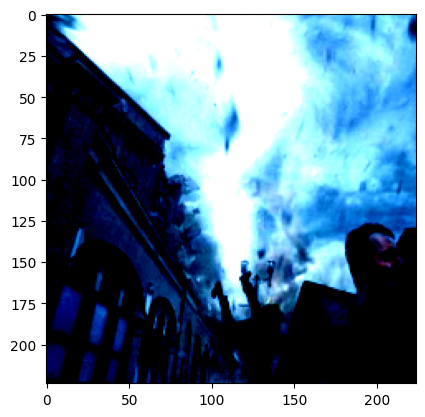

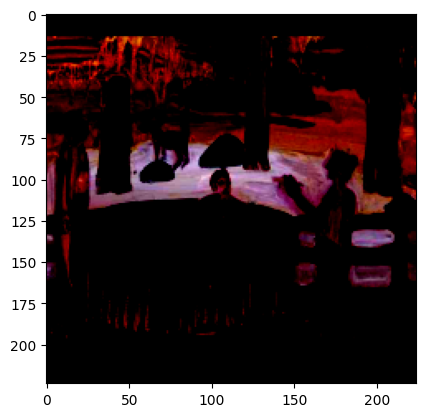

In [8]:
for i,batch in enumerate(dataloader['train']):
    data = organize_batch(batch, batch_size, two_task)
    for task in two_task:
        x, y = data['%s_img' % task], data['%s_gt' % task]
        plt.figure()
        plt.imshow(x[0].numpy().transpose(1,2,0))
        print(y[0])
    break

#### for model

In [10]:
model

EffNetV2(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): MBConv(
      (conv): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (stochastic_depth): StochasticDepth(p=0.0, mode=row)
    )
    (2): MBConv(
      (conv): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (stochastic_depth): StochasticDepth(p=0.005, mode=row)
    )
    (3): MBConv(
      (conv): Sequential(
        (0): Conv2d

In [7]:
flops, params = get_model_complexity_info(model, (3, 321, 321), print_per_layer_stat=True, verbose=False)
print('Flops: {}, Params: {}'.format(flops,params), flush=True)

EffNetV2(
  21.46 M, 100.000% Params, 6.37 GMac, 100.000% MACs, 
  (features): Sequential(
    20.18 M, 94.030% Params, 6.37 GMac, 99.977% MACs, 
    (0): Sequential(
      696, 0.003% Params, 18.04 MMac, 0.283% MACs, 
      (0): Conv2d(648, 0.003% Params, 16.8 MMac, 0.264% MACs, 3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, 0.000% Params, 1.24 MMac, 0.020% MACs, 24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(0, 0.000% Params, 0.0 Mac, 0.000% MACs, inplace=True)
    )
    (1): MBConv(
      5.23 k, 0.024% Params, 135.62 MMac, 2.129% MACs, 
      (conv): Sequential(
        5.23 k, 0.024% Params, 135.62 MMac, 2.129% MACs, 
        (0): Conv2d(5.18 k, 0.024% Params, 134.37 MMac, 2.109% MACs, 24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(48, 0.000% Params, 1.24 MMac, 0.020% MACs, 24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      

In [7]:
flops = [0.283, 2.129, 2.129, 2.640, 9.542, 9.542, 9.542, 2.527, 4.340, 4.340, 4.340, 0.696, 0.959, 0.959, 0.959, 0.959, 0.959,
1.609, 2.223, 2.223, 2.223, 2.223, 2.223, 2.223, 2.223, 2.223, 1.568, 1.539, 1.539, 1.539, 1.539, 1.539, 1.539, 1.539,
1.539, 1.539, 1.539, 1.539, 1.539, 1.539, 1.539, 0.627]

In [18]:
total,temp = sum(flops)//4,0
mapping = {}
curr_b, curr_lst = 0, []
for idx, fl in enumerate(flops):
    temp += fl
    curr_lst.append(idx)
    if temp > total:
        curr_lst.pop()
        mapping[curr_b] = curr_lst
        curr_b += 1
        curr_lst = [idx]
        temp = fl
mapping[curr_b] = curr_lst
print(mapping)

{0: [0, 1, 2, 3, 4], 1: [5, 6, 7], 2: [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18], 3: [19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], 4: [31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]}


In [10]:
mapping = {0: [0, 1, 2, 3, 4, 5, 6], 1: [7, 8, 9, 10],
           2: [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25],
           3: [26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]}
for key in mapping:
    i,j = min(mapping[key]),max(mapping[key])
    print(sum(flops[i:j+1]))

35.807
15.547
24.883999999999993
23.741000000000003


In [11]:
cfgs = [
        # t, c, n, s, SE for EffNet_s
        [1,  24,  2, 1, 0],
        [4,  48,  4, 2, 0],
        [4,  64,  4, 2, 0],
        [4, 128,  6, 2, 1],
        [6, 160,  9, 1, 1],
        [6, 256, 15, 2, 1],
        ]
sum([cfgs[i][2] for i in range(len(cfgs))])+2

42